# Face Mask Detection Using Convolutional Neural Networks

This notebook demonstrates the process of building and training a convolutional neural network to detect whether individuals in video streams are wearing masks. We'll go through data loading, preprocessing, model building, training, and evaluation.


## Import Libraries

Import all necessary libraries that will be used throughout the notebook. This includes libraries for data handling, numerical operations, machine learning, and image processing.


In [1]:
import platform
import psutil
import torch
import logging
import os
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F
from tqdm import tqdm
import json
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
# Setting up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
def print_system_info():
    print(f"Operating System: {platform.system()} {platform.release()}")
    print(f"Version: {platform.version()}")
    print(f"Machine: {platform.machine()}")
    print(f"Processor: {platform.processor()}")
    print(f"RAM: {psutil.virtual_memory().total / (1024.0 ** 3):.2f} GB")
    print(f"CPU Cores: {psutil.cpu_count(logical=False)} Physical, {psutil.cpu_count(logical=True)} Logical")
    print(f"Python Version: {platform.python_version()}")
    
    # GPU information using PyTorch
    if torch.cuda.is_available():
        print(f"Total GPUs: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}, Memory: {torch.cuda.get_device_properties(i).total_memory / (1024 ** 3):.2f} GB")
    else:
        print("No NVIDIA GPUs detected")

print_system_info()

Operating System: Linux 3.10.0-1160.49.1.el7.x86_64
Version: #1 SMP Tue Nov 30 15:51:32 UTC 2021
Machine: x86_64
Processor: x86_64
RAM: 503.40 GB
CPU Cores: 64 Physical, 64 Logical
Python Version: 3.9.20
Total GPUs: 1
GPU 0: NVIDIA A100-SXM4-40GB, Memory: 39.39 GB


## Load and Preprocess Data

This section details the process of loading the image data from the filesystem, filtering out non-image files, converting images to a uniform size, and storing them for further processing. We ensure that only files with valid image extensions are processed to avoid errors during loading.

### Function Definitions

- `is_image_file`: Checks if the file has a valid image file extension.
- `load_data`: Iterates through the dataset, loads each image, resizes it, and appends it to a list while assigning labels based on the directory structure.

These functions help in creating a streamlined pipeline for data handling which is crucial for the consistency and effectiveness of the model training process.


In [3]:
def is_image_file(filename):
    # Check for common image file extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    return any(filename.endswith(extension) for extension in valid_extensions)

def load_data(data_path):
    categories = ['with_mask', 'without_mask']
    data = []
    labels = []

    for category in categories:
        path = os.path.join(data_path, category)
        class_num = categories.index(category)
        for img in filter(is_image_file, os.listdir(path)):  # Filter to process only image files
            img_path = os.path.join(path, img)
            try:
                image = Image.open(img_path).convert('RGB')
                image = image.resize((128, 128))  # Resize the image
                data.append(image)  # Append the PIL image directly
                labels.append(class_num)
            except Exception as e:
                logging.error(f"Error loading image {img_path}: {e}")
    return data, labels

## Define the Dataset Class

This section introduces a custom dataset class, `CustomDataset`, which is utilized to handle the transformation and batching of image data. This class inherits from PyTorch's `Dataset` module, making it compatible with PyTorch's data loading and preprocessing utilities.

### Class Details:

- `__init__`: Initializes the dataset object with images, labels, and optional transformations.
- `__len__`: Returns the total number of images in the dataset.
- `__getitem__`: Retrieves an image by index, applies transformations if any, and returns the transformed image along with its corresponding label.

The `CustomDataset` class encapsulates the complexity of data handling within a dataset object, allowing for easy integration with PyTorch's DataLoader for efficient batching during training.


In [4]:
# Dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Initialize the dataset with images and labels.
        :param images: List of image data (PIL images).
        :param labels: List of labels corresponding to the images.
        :param transform: A torchvision.transforms instance defining data transformation.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        """
        Return the total number of samples in the dataset.
        """
        return len(self.images)

    def __getitem__(self, idx):
        """
        Fetch an item by index. Applies transformation to the image.
        :param idx: Index of the item.
        :return: Tuple of transformed image and its label.
        """
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

## Data Preparation and Loading

In this section, we set up the necessary transformations, load our dataset, split it into training and validation sets, and prepare data loaders for batch processing. These steps are essential for effective model training and validation.

### Steps Covered:

1. **Transformation Setup**:
   - We define a series of transformations using `transforms.Compose` to resize the images to 128x128 pixels, convert them to tensors, and normalize them using the specified mean and standard deviations. This normalization helps in stabilizing the training process and is tailored to work well with models pre-trained on ImageNet data.

2. **Data Loading**:
   - The function `load_data` is called with the specified data path to load images and their corresponding labels. This function ensures that only valid image files are processed.

3. **Train-Validation Split**:
   - The dataset is split into training and validation subsets to evaluate the model's performance and mitigate overfitting. We use a typical split ratio where 80% of the data is used for training and 20% for validation.

4. **Data Loader Setup**:
   - `DataLoader` objects are created for both training and validation datasets. These loaders provide an efficient way to iterate over the datasets in batches, which is crucial for training deep learning models.

By organizing the dataset into manageable batches and applying consistent transformations, we prepare our data for efficient training and validation processes, ensuring that our model learns effectively and generalizes well.


In [5]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load data
data_path = './data'
images, labels = load_data(data_path)

# Split data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42
)
logging.info(f"Data split into {len(train_images)} training and {len(val_images)} validation samples.")


# Create datasets and data loaders
train_dataset = CustomDataset(train_images, train_labels, transform=transform)
val_dataset = CustomDataset(val_images, val_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

logging.info("Data loaders created, ready to train and validate model.")

/home/pendem.mu/.conda/envs/pytorch_env_new/lib/python3.9/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
2024-12-23 02:35:30,787 - INFO - Data split into 6042 training and 1511 validation samples.
2024-12-23 02:35:30,789 - INFO - Data loaders created, ready to train and validate model.


## Visualizing Sample Images

Before diving into the model training, let's visualize one sample image from each class ('with_mask' and 'without_mask'). This will help us understand the data better and ensure that our image loading mechanism is working correctly.

### Explanation:

1. **Path Setup**:
   - We define the paths to the directories containing images of people 'with_mask' and 'without_mask'. This organization helps in managing different categories of data efficiently.

2. **Random Image Selection**:
   - To provide a quick glimpse into the dataset, one image from each category is randomly selected. This randomization helps in showcasing typical examples from our dataset without any bias.

3. **Image Loading and Display**:
   - The selected images are loaded using the PIL library, which is well-suited for handling various image formats and processing tasks.
   - We then display these images side-by-side using `matplotlib` to provide a clear visual comparison between the two classes.

This visualization is not only a good sanity check but also provides insight into the challenges of the task, such as varying lighting conditions, different facial orientations, and potential occlusions.


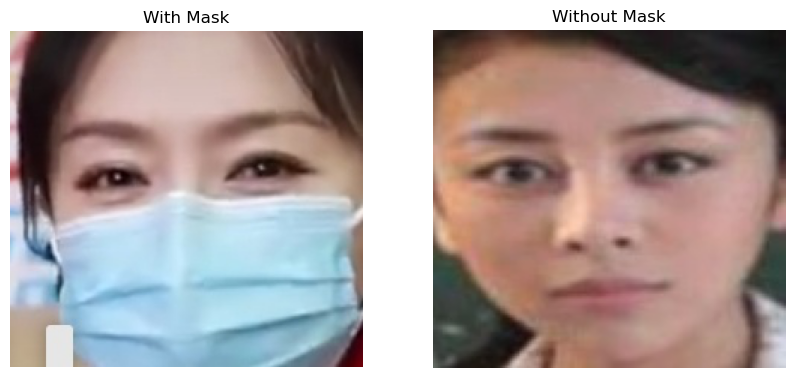

In [6]:
# Define paths to the 'with_mask' and 'without_mask' directories
with_mask_path = os.path.join(data_path, 'with_mask')
without_mask_path = os.path.join(data_path, 'without_mask')

# Randomly choose an image from each directory
with_mask_image_file = random.choice(os.listdir(with_mask_path))
without_mask_image_file = random.choice(os.listdir(without_mask_path))

# Full paths to the randomly chosen images
with_mask_image_path = os.path.join(with_mask_path, with_mask_image_file)
without_mask_image_path = os.path.join(without_mask_path, without_mask_image_file)

# Load images using PIL
with_mask_image = Image.open(with_mask_image_path)
without_mask_image = Image.open(without_mask_image_path)

# Create a figure with subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Display the first image (with mask)
ax[0].imshow(with_mask_image)
ax[0].set_title('With Mask')
ax[0].axis('off')  # Hide the axes

# Display the second image (without mask)
ax[1].imshow(without_mask_image)
ax[1].set_title('Without Mask')
ax[1].axis('off')  # Hide the axes

plt.show()


## CNN Architecture for Mask Detection

This section details the architecture of the convolutional neural network (CNN) used for mask detection. The model is designed to process images and predict whether a person is wearing a mask or not.

### Model Structure:

1. **Convolutional Layers**:
   - **First Convolutional Layer**: Applies 32 filters with a kernel size of 3x3 and padding of 1. This layer captures basic features like edges and textures.
   - **Second Convolutional Layer**: Increases the depth to 64 filters, helping the model to learn more complex features.
   - **Third Convolutional Layer**: Further deepens to 128 filters, allowing the capture of even more complex features from the input images.
   - Each convolutional layer is followed by a max-pooling layer with a size of 2x2, which reduces the spatial dimensions of the output and helps in making the model more robust to variations in the image.

2. **Fully Connected (FC) Layers**:
   - **First FC Layer**: Flattens the output from the last pooling layer and connects it to 256 neurons. This layer begins the process of classification.
   - **Second FC Layer**: Further condenses the model to 128 neurons, focusing on the essential information needed for the final prediction.
   - **Output Layer**: Consists of 2 neurons corresponding to the two classes ('with_mask' and 'without_mask'). It uses the softmax activation function to output the probabilities for each class.

### Activation Function:
- **ReLU (Rectified Linear Unit)**: Used in all convolutional and fully connected layers except for the output layer to introduce non-linearity into the model, allowing it to learn more complex patterns.

### Summary:
This CNN model is structured to progressively abstract and condense information, with successive layers capturing increasingly complex and high-level features. The max-pooling layers help reduce computational complexity and control overfitting. The final fully connected layers focus on classifying the features extracted by the convolutional layers into the two categories, mask or no mask.


In [7]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # Adjust the sizing based on output from last pool
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)  # Adjust flattening based on pool output size
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


## Training the CNN Model for Mask Detection

This section outlines the code and process used to train the convolutional neural network (CNN) for detecting whether individuals are wearing masks. The training process is performed on a GPU if available, ensuring faster computations.

### Setup and Initialization:
- **Device Setup**: Determines if CUDA is available for GPU acceleration; otherwise, it defaults to CPU.
- **Model Instantiation**: The `CNNModel` is instantiated and loaded onto the appropriate device (GPU or CPU).
- **Loss Function**: Uses Cross Entropy Loss, ideal for classification tasks with two or more label classes.
- **Optimizer**: Adam optimizer, known for its efficiency in handling large datasets and non-stationary objectives.

### Training Process:
- **Epochs**: The model trains over a predefined number of epochs, iterating over the entire dataset multiple times.
- **Batch Processing**: Data is processed in batches, which helps in optimizing the training speed and memory usage.
- **Loss Calculation**: For each batch, the loss is calculated to gauge the difference between the model's predictions and the actual labels.
- **Backpropagation**: The gradients of the loss function are propagated back through the network to update the weights, minimizing the loss.
- **Accuracy Tracking**: For each epoch, the accuracy is computed to monitor the model's performance on training data.

### Model Saving and Logging:
- **Model Checkpointing**: After each epoch, if the model achieves a higher accuracy than previously observed, it is saved. This mechanism ensures that the best performing model is retained.
- **Logging**: Records the loss and accuracy for each epoch into a log file for later analysis.
- **Metrics Saving**: At the end of training, metrics such as loss and accuracy for each epoch are saved into a JSON file, facilitating easy access and visualization.

### Key Considerations:
- The model's performance depends significantly on the number of epochs, batch size, and the learning rate of the optimizer.
- Regular logging and saving of the model checkpoints allow for effective monitoring and recovery of the model's best state.

By following these steps, the CNN model is trained to effectively distinguish between 'with_mask' and 'without_mask' conditions, aiming to deploy this model in real-world scenarios for enhancing public health measures.


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    metrics = []
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        total_loss = 0
        total_correct = 0
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()

        avg_loss = total_loss / len(train_loader.dataset)
        avg_acc = total_correct / len(train_loader.dataset)
        logging.info(f'Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {avg_acc:.4f}')
        metrics.append({'epoch': epoch+1, 'loss': avg_loss, 'accuracy': avg_acc})

        if avg_acc > best_accuracy:
            best_accuracy = avg_acc
            torch.save(model.state_dict(), 'best_model_cnn_deep.pth')
            logging.info(f'New best model saved with accuracy: {best_accuracy:.4f}')

    with open('metrics.json', 'w') as f:
        json.dump(metrics, f, indent=4)

In [9]:
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10: 100%|██████████| 189/189 [00:56<00:00,  3.33it/s]
2024-12-23 02:36:27,993 - INFO - Epoch 1: Loss = 0.3296, Accuracy = 0.8537
2024-12-23 02:36:28,112 - INFO - New best model saved with accuracy: 0.8537
Epoch 2/10: 100%|██████████| 189/189 [00:20<00:00,  9.35it/s]
2024-12-23 02:36:48,325 - INFO - Epoch 2: Loss = 0.2067, Accuracy = 0.9172
2024-12-23 02:36:48,437 - INFO - New best model saved with accuracy: 0.9172
Epoch 3/10: 100%|██████████| 189/189 [00:51<00:00,  3.69it/s]
2024-12-23 02:37:39,610 - INFO - Epoch 3: Loss = 0.1405, Accuracy = 0.9444
2024-12-23 02:37:39,703 - INFO - New best model saved with accuracy: 0.9444
Epoch 4/10: 100%|██████████| 189/189 [01:15<00:00,  2.51it/s]
2024-12-23 02:38:55,048 - INFO - Epoch 4: Loss = 0.0930, Accuracy = 0.9662
2024-12-23 02:38:55,183 - INFO - New best model saved with accuracy: 0.9662
Epoch 5/10: 100%|██████████| 189/189 [01:22<00:00,  2.30it/s]
2024-12-23 02:40:17,430 - INFO - Epoch 5: Loss = 0.0465, Accuracy = 0.9848
2024-12-23 

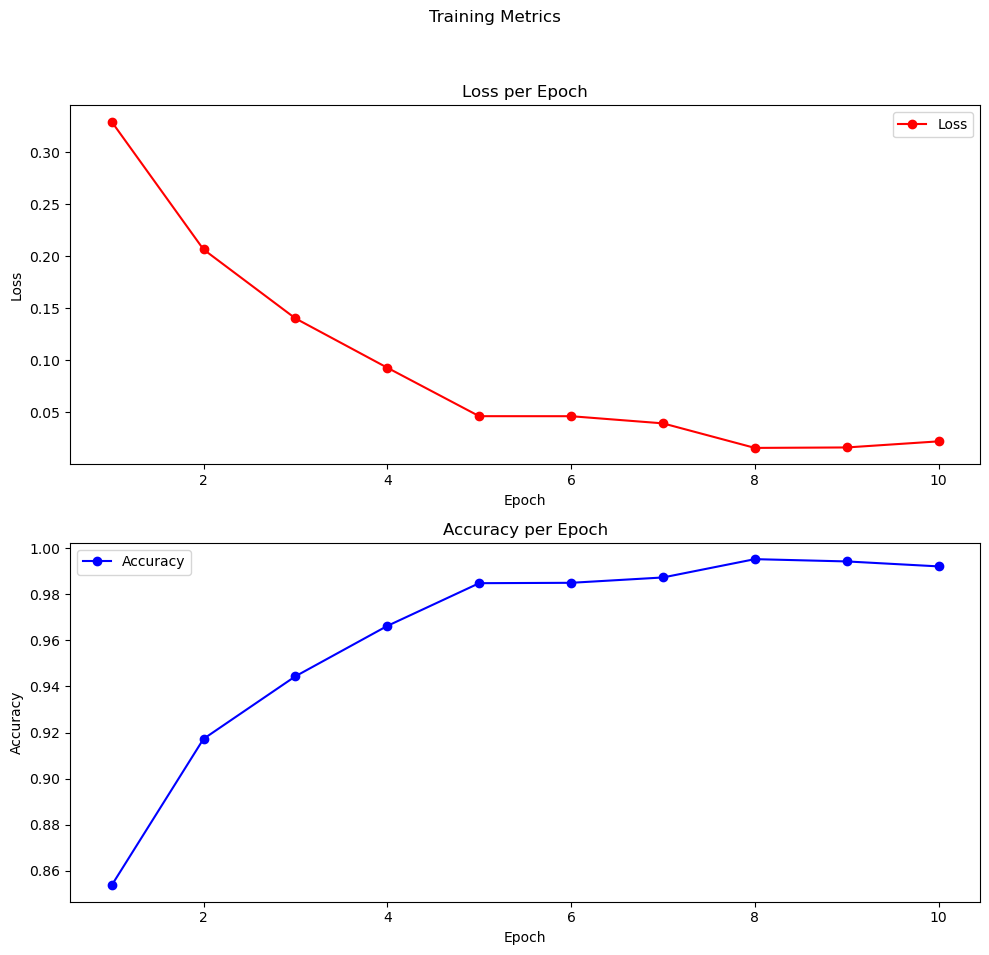

In [10]:
# Load JSON data
with open('metrics.json', 'r') as file:
    data = json.load(file)

# Convert JSON to DataFrame
df = pd.DataFrame(data)

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
fig.suptitle('Training Metrics')

# Plot Loss
axes[0].plot(df['epoch'], df['loss'], marker='o', color='red', label='Loss')
axes[0].set_title('Loss per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot Accuracy
axes[1].plot(df['epoch'], df['accuracy'], marker='o', color='blue', label='Accuracy')
axes[1].set_title('Accuracy per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [11]:
# Load the model
def load_model(model, path='best_model_cnn_deep.pth'):
    model.load_state_dict(torch.load(path))
    model.eval()  # Set the model to evaluation mode
    return model

# Assuming the model class has been defined
model = CNNModel().to(device)
model = load_model(model, 'best_model_cnn_deep.pth')

# Test the model
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

test_model(model, val_loader)


/tmp/ipykernel_2669/509589695.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Test Accuracy: 95.30%


In [12]:
def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)  # Apply the same transforms as during training
    image = image.unsqueeze(0).to(device)  # Add batch dimension and send to device

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    return 'With Mask' if predicted.item() == 0 else 'Without Mask'  # Check the correct association of labels

## Utilizing the Trained CNN Model for Mask Detection on a Single Image

This section demonstrates how to use the previously trained CNN model to predict whether a person in a given image is wearing a mask. The prediction is carried out on a single image whose path is specified.

### Setup and Image Prediction:
- **Device Setup**: Checks if a GPU is available for the model to utilize, otherwise defaults to CPU.
- **Model Loading**: The pre-trained CNN model is loaded with the best weights saved during training.
- **Image Path**: The path to the image to be tested is defined.
- **Prediction Execution**: The `predict_image` function processes the image, predicts using the CNN model, and interprets the output to determine if the person is wearing a mask.

### Functions and Processing:
- **Model Preparation**: The model is transferred to the appropriate device (GPU or CPU) and set to evaluation mode.
- **Image Loading and Transformation**: The image is loaded, resized to match the training input size, and normalized.
- **Prediction and Output**: The model makes a prediction on the processed image. The result is decoded from the model's output to a human-readable form, indicating whether a mask is detected or not.

### Displaying Results:
- After processing, the prediction result is displayed, informing the user whether the person in the image is wearing a mask.

This method can be easily integrated into a larger system for real-time mask detection or batch processing of images to assess mask compliance in different settings.

### Key Considerations:
- Ensure the model path and image path are correctly specified.
- Image preprocessing should align with the transformations applied during model training.
- The model should be adequately tested to handle different lighting conditions and face orientations for robust mask detection.


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_path = './1.jpg'  # Update this path
model = CNNModel().to(device)
model = load_model(model, 'best_model_cnn_deep.pth')
predicted_label = predict_image(image_path, model, transform, device)
print(f'The person in the image is predicted to be: {predicted_label}')

The person in the image is predicted to be: With Mask


/tmp/ipykernel_2669/509589695.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))
